# Forecasting strong lensing rates

The goal of this notebook is to forecast the number of detectable strongly lensed gravitational wave (GW) events from binary black hole (BBH) mergers for different GW detector networks. 

In [1]:
import numpy as np
from scipy.integrate import trapz
#from scipy.integrate import cumulative_trapezoid as cumtrapz
from astropy.cosmology import Planck18 as cosmo

from gw_lensing.utils.constants import *
from gw_lensing.utils import gwutils
from gw_lensing.gw_population import gwpop
from gw_lensing.utils import utils
from gw_lensing.detectors import sensitivity_curves as sc
from gw_lensing.gw_rates import rates
from gw_lensing.lensing_rates import sis_rates as sisrates
from gw_lensing.lens_models import sis
from gw_lensing.optical_depth import sis_optical_depth as sistau

In [2]:
#PLOTTING MODULES
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fontSZ = 17
fontSz = 15
fontsz = 13
fontssz = 11

new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

import sys
dir_base=sys.path[0]
dir_out=dir_base+"/plots_optical_depth/"

## Binary balck hole population model

We use standard assumptions for the binary black holes population:
- Merger rate density as a function of redshift following the Madau-Dickinson-like star formation fitted to GW observations
- Mass distribution following a smooth power-law+peak with uniform distribution in mass ratio

We fix all parameters to the median values obtained from the analysis of the GWTC-4 catalog in [1], except for the redshift evolution parameter $\kappa$ which we will vary to see its impact on the lensing rates. 
We will also vary the local merger rate $R_0$. We will consider the 90% credible interval for both parameters and define the most optimistic and pessimistic scenarios for the lensing rates as the ones with the largest and smallest values of both $R_0$ and $\kappa$.

[1] https://arxiv.org/abs/2508.18083

In [3]:
from fiducial_universe_gwtc4 import *

R_0p2_bbh_fid = 29.0 #yr^-1 Gpc^-3
R_0p2_bbh_up = R_0p2_bbh_fid + 8.5 #yr^-1 Gpc^-3
R_0p2_bbh_low = R_0p2_bbh_fid - 6.5 #yr^-1 Gpc^-3
kappa_fid = 3.2
kappa_up = kappa_fid + 0.94
kappa_low = kappa_fid - 1.0
mmin_bbh = mmin_pl_fid
mmax_bbh = mmax_pl_fid


In [4]:
def pz_fid(z):
    return gwpop.rate_z_norm_0p2(z,zp_fid,kappa_fid,beta_fid)
def pz_up(z):
    return gwpop.rate_z_norm_0p2(z,zp_fid,kappa_up,beta_fid)
def pz_low(z):
    return gwpop.rate_z_norm_0p2(z,zp_fid,kappa_low,beta_fid)

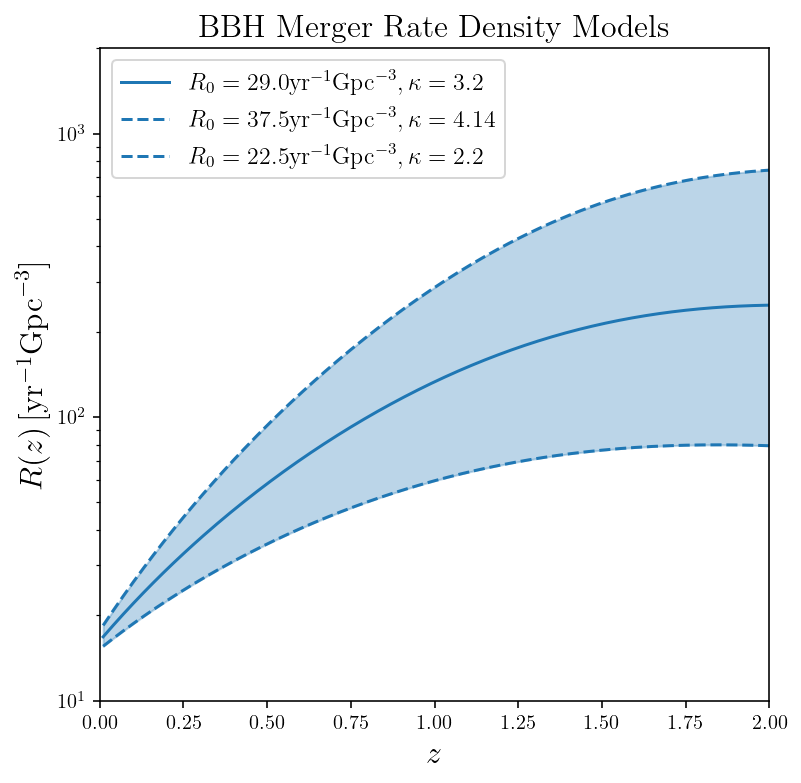

In [5]:
zs = np.linspace(0.01, 2., 200)
Rz_fid = R_0p2_bbh_fid * pz_fid(zs)
Rz_up = R_0p2_bbh_up * pz_up(zs)
Rz_low = R_0p2_bbh_low * pz_low(zs)

plt.figure(figsize=(6,6))
plt.fill_between(zs,Rz_low,Rz_up,color=new_colors[0],alpha=0.3)
plt.plot(zs,Rz_fid,color=new_colors[0],label=r'$R_0=29.0 \mathrm{yr}^{-1} \mathrm{Gpc}^{-3}, \kappa=3.2$')
plt.plot(zs,Rz_up,color=new_colors[0],ls='--',label=r'$R_0=37.5 \mathrm{yr}^{-1} \mathrm{Gpc}^{-3}, \kappa=4.14$')
plt.plot(zs,Rz_low,color=new_colors[0],ls='--',label=r'$R_0=22.5 \mathrm{yr}^{-1} \mathrm{Gpc}^{-3}, \kappa=2.2$')
plt.xlabel(r'$z$',fontsize=16)
plt.ylabel(r'$R(z) \, [\mathrm{yr}^{-1} \mathrm{Gpc}^{-3}]$',fontsize=16)
plt.ylim(1e1,2e3)
plt.xlim(0,2)
plt.legend(fontsize=12)
plt.yscale('log')
plt.title('BBH Merger Rate Density Models',fontsize=16)
plt.show()

In [6]:
def pm1_bbh(mass_1):
    mMin_pl = mmin_pl_fid
    mMax_pl = mmax_pl_fid
    alpha = alpha_fid
    sig_m1 = sig_m1_fid
    mu_m1 = mu_m1_fid
    f_peak = f_peak_fid
    mMin_filter = mMin_filter_fid
    mMax_filter = mMax_filter_fid
    dmMin_filter = dmMin_filter_fid
    dmMax_filter = dmMax_filter_fid

    return gwpop.powerlaw_peak_smooth(mass_1,mMin_pl,mMax_pl,alpha,sig_m1,mu_m1,f_peak,mMin_filter,mMax_filter,dmMin_filter,dmMax_filter)

def pq_bbh(q):
    bq = bq_fid
    return utils.powerlaw(q,0.,1.,bq)

def pm2_bbh(mass_2,mass_1):
    q = mass_2/mass_1
    return pq_bbh(q)/mass_1

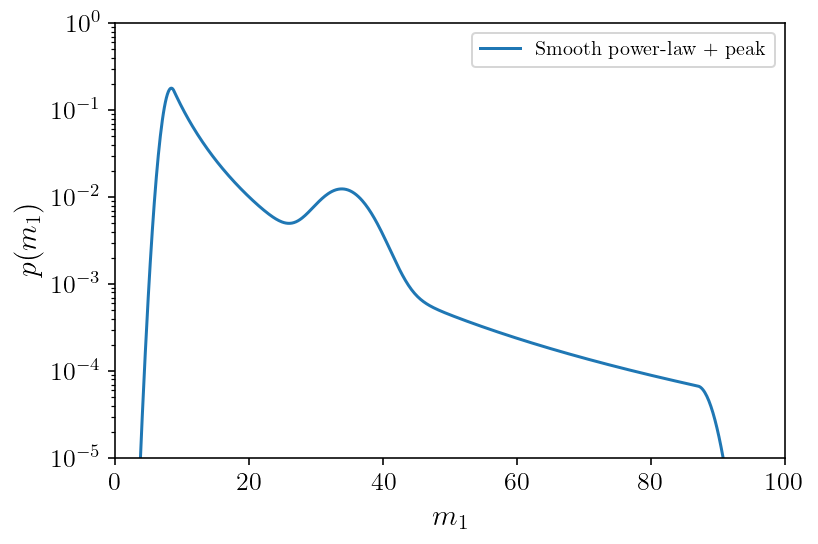

In [7]:
ms = np.linspace(0.1, 150, 1000)
pm = pm1_bbh(ms)
pm = pm/np.trapz(pm,ms)

plt.plot(ms, pm,label='Smooth power-law + peak')
plt.xlabel(r'$m_1$',fontsize=fontSz)
plt.ylabel(r'$p(m_1)$',fontsize=fontSz)
plt.tick_params(axis='both', which='major', labelsize=fontsz)
plt.yscale('log')
plt.ylim(1e-5,1e0)
plt.xlim(0,100)
plt.legend()
plt.show()

## GW detectors

In [8]:
Sn_O4, fmin_O4, fmax_O4 = sc.detector_psd('O4')
Sn_Aplus, fmin_Aplus, fmax_Aplus = sc.detector_psd('A+')
Sn_Asharp, fmin_Asharp, fmax_Asharp = sc.detector_psd('A#')
Sn_CE, fmin_CE, fmax_CE = sc.detector_psd('CE-40')
based = 'ground'
snr_th = 8.
Tobs = 1. #yr

In [9]:
zmin = 0.01
zmax = 10.

n_m1 = 50 #number of mass bins
n_m2 = 10 #number of mass bins
n_z = 50 #number of redshift bins

m1s_bbh = np.linspace(mmin_bbh,mmax_bbh,1000)
norm_m1_bbh = 1./trapz(pm1_bbh(m1s_bbh),m1s_bbh)

Nbbh_fid = np.round(rates.Ncbc(pz_fid,R_0p2_bbh_fid,H0_fid,Om0_fid,Tobs,zmin,zmax,n_z),2)
Nbbh_up = np.round(rates.Ncbc(pz_up,R_0p2_bbh_up,H0_fid,Om0_fid,Tobs,zmin,zmax,n_z),2)
Nbbh_low = np.round(rates.Ncbc(pz_low,R_0p2_bbh_low,H0_fid,Om0_fid,Tobs,zmin,zmax,n_z),2)
print('BBHs per year (fid): ',Nbbh_fid)
print('BBHs per 5 minute (fid): ',Nbbh_fid/YEAR*60*5)
print('BBHs per year (up): ',Nbbh_up)
print('BBHs per year (low): ',Nbbh_low)

BBHs per year (fid):  118222.31
BBHs per 5 minute (fid):  1.1238521036920155
BBHs per year (up):  335499.76
BBHs per year (low):  40566.36


In [21]:
Nbbh_O4_fid = rates.Ndet(pz_fid,pm1_bbh,pm2_bbh,R_0p2_bbh_fid,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_O4,fmin_O4,fmax_O4,based,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected BBHs per year (O4): ',Nbbh_O4_fid)
Nbbh_O4_up = rates.Ndet(pz_up,pm1_bbh,pm2_bbh,R_0p2_bbh_up,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_O4,fmin_O4,fmax_O4,based,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected BBHs per year (O4, up): ',Nbbh_O4_up)
Nbbh_O4_low = rates.Ndet(pz_low,pm1_bbh,pm2_bbh,R_0p2_bbh_low,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_O4,fmin_O4,fmax_O4,based,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected BBHs per year (O4, low): ',Nbbh_O4_low)

print('')
Nbbh_Aplus_fid = rates.Ndet(pz_fid,pm1_bbh,pm2_bbh,R_0p2_bbh_fid,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_Aplus,fmin_Aplus,fmax_Aplus,based,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected BBHs per year (A+): ',Nbbh_Aplus_fid)
Nbbh_Aplus_up = rates.Ndet(pz_up,pm1_bbh,pm2_bbh,R_0p2_bbh_up,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_Aplus,fmin_Aplus,fmax_Aplus,based,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected BBHs per year (A+, up): ',Nbbh_Aplus_up)
Nbbh_Aplus_low = rates.Ndet(pz_low,pm1_bbh,pm2_bbh,R_0p2_bbh_low,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_Aplus,fmin_Aplus,fmax_Aplus,based,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected BBHs per year (A+, low): ',Nbbh_Aplus_low)

print('')
Nbbh_Asharp_fid = rates.Ndet(pz_fid,pm1_bbh,pm2_bbh,R_0p2_bbh_fid,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_Asharp,fmin_Asharp,fmax_Asharp,based,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected BBHs per year (A#): ',Nbbh_Asharp_fid)
Nbbh_Asharp_up = rates.Ndet(pz_up,pm1_bbh,pm2_bbh,R_0p2_bbh_up,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_Asharp,fmin_Asharp,fmax_Asharp,based,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected BBHs per year (A#, up): ',Nbbh_Asharp_up)
Nbbh_Asharp_low = rates.Ndet(pz_low,pm1_bbh,pm2_bbh,R_0p2_bbh_low,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_Asharp,fmin_Asharp,fmax_Asharp,based,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected BBHs per year (A#, low): ',Nbbh_Asharp_low)

print('')
Nbbh_CE_fid = rates.Ndet(pz_fid,pm1_bbh,pm2_bbh,R_0p2_bbh_fid,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_CE,fmin_CE,fmax_CE,based,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected BBHs per year (CE): ',Nbbh_CE_fid)
Nbbh_CE_up = rates.Ndet(pz_up,pm1_bbh,pm2_bbh,R_0p2_bbh_up,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_CE,fmin_CE,fmax_CE,based,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected BBHs per year (CE, up): ',Nbbh_CE_up)
Nbbh_CE_low = rates.Ndet(pz_low,pm1_bbh,pm2_bbh,R_0p2_bbh_low,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_CE,fmin_CE,fmax_CE,based,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected BBHs per year (CE, low): ',Nbbh_CE_low)

Detected BBHs per year (O4):  167.87536917140363
Detected BBHs per year (O4, up):  265.5308219211839
Detected BBHs per year (O4, low):  108.31497850900746

Detected BBHs per year (A+):  1149.1605178949858
Detected BBHs per year (A+, up):  2263.9632100149656
Detected BBHs per year (A+, low):  602.6516614598991

Detected BBHs per year (A#):  6980.796703323219
Detected BBHs per year (A#, up):  16470.267354613337
Detected BBHs per year (A#, low):  3025.7774940949403

Detected BBHs per year (CE):  101029.76038807018
Detected BBHs per year (CE, up):  285339.2873292113
Detected BBHs per year (CE, low):  34895.629307606505


## Strong Lensing GW rates

We model the entire population of lenses using the [Tinker et al. 2008](https://arxiv.org/abs/0803.2706) halo mass function implemented in [collosus](https://bdiemer.bitbucket.io/colossus/lss_mass_function.html#lss.mass_function.modelTinker08).

The lenses are chosen to have a singular isothermal sphere (SIS) profile. 

We compute the rates for the primary and secondary images separately.

In [22]:
log10MLmin = 6
log10MLmax = 16
nMLs = 100
nzLs = 100

The rate of lensed BBHs, not necessarily detected, can be computed as

In [23]:
Nbbh_lens_fid = sisrates.Ncbc_lens(pz_fid,R_0p2_bbh_fid,H0_fid,Om0_fid,Tobs,log10MLmin,log10MLmax,nMLs,nzLs,zmin,zmax,n_z)

print('BBHs per year: ',Nbbh_fid)
print('Lensed BBHs per year: ',Nbbh_lens_fid)

BBHs per year:  118222.31
Lensed BBHs per year:  125.1033100602315


## Strongly lensed GW image detection rates

We will compute the number of detectable lensed GW events for different detector networks. We consider a singular isothermal sphere (SIS) model for the lens population. We compute the rates for the primary and secondary images separately.

In [24]:
nys = 50

Brightest image

In [25]:
Nbbh_lens_mup_O4_fid = sisrates.Ndet_lens_mu(pz_fid,pm1_bbh,pm2_bbh,R_0p2_bbh_fid,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_O4,fmin_O4,fmax_O4,based,log10MLmin,log10MLmax,nMLs,nzLs,sis.mu_plus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected lensed primary image of BBHs per year (O4): ',Nbbh_lens_mup_O4_fid)
Nbbh_lens_mup_O4_up = sisrates.Ndet_lens_mu(pz_up,pm1_bbh,pm2_bbh,R_0p2_bbh_up,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_O4,fmin_O4,fmax_O4,based,log10MLmin,log10MLmax,nMLs,nzLs,sis.mu_plus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected lensed primary image of BBHs per year (O4, up): ',Nbbh_lens_mup_O4_up)
Nbbh_lens_mup_O4_low = sisrates.Ndet_lens_mu(pz_low,pm1_bbh,pm2_bbh,R_0p2_bbh_low,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_O4,fmin_O4,fmax_O4,based,log10MLmin,log10MLmax,nMLs,nzLs,sis.mu_plus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected lensed primary image of BBHs per year (O4, low): ',Nbbh_lens_mup_O4_low)

print(' ')
Nbbh_lens_mup_Aplus_fid = sisrates.Ndet_lens_mu(pz_fid,pm1_bbh,pm2_bbh,R_0p2_bbh_fid,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_Aplus,fmin_Aplus,fmax_Aplus,based,log10MLmin,log10MLmax,nMLs,nzLs,sis.mu_plus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected lensed primary image of BBHs per year (A+): ',Nbbh_lens_mup_Aplus_fid)
Nbbh_lens_mup_Aplus_up = sisrates.Ndet_lens_mu(pz_up,pm1_bbh,pm2_bbh,R_0p2_bbh_up,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_Aplus,fmin_Aplus,fmax_Aplus,based,log10MLmin,log10MLmax,nMLs,nzLs,sis.mu_plus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected lensed primary image of BBHs per year (A+, up): ',Nbbh_lens_mup_Aplus_up)
Nbbh_lens_mup_Aplus_low = sisrates.Ndet_lens_mu(pz_low,pm1_bbh,pm2_bbh,R_0p2_bbh_low,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_Aplus,fmin_Aplus,fmax_Aplus,based,log10MLmin,log10MLmax,nMLs,nzLs,sis.mu_plus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected lensed primary image of BBHs per year (A+, low): ',Nbbh_lens_mup_Aplus_low)

print(' ')
Nbbh_lens_mup_Asharp_fid = sisrates.Ndet_lens_mu(pz_fid,pm1_bbh,pm2_bbh,R_0p2_bbh_fid,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_Asharp,fmin_Asharp,fmax_Asharp,based,log10MLmin,log10MLmax,nMLs,nzLs,sis.mu_plus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected lensed primary image of BBHs per year (A#): ',Nbbh_lens_mup_Asharp_fid)
Nbbh_lens_mup_Asharp_up = sisrates.Ndet_lens_mu(pz_up,pm1_bbh,pm2_bbh,R_0p2_bbh_up,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_Asharp,fmin_Asharp,fmax_Asharp,based,log10MLmin,log10MLmax,nMLs,nzLs,sis.mu_plus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected lensed primary image of BBHs per year (A#, up): ',Nbbh_lens_mup_Asharp_up)
Nbbh_lens_mup_Asharp_low = sisrates.Ndet_lens_mu(pz_low,pm1_bbh,pm2_bbh,R_0p2_bbh_low,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_Asharp,fmin_Asharp,fmax_Asharp,based,log10MLmin,log10MLmax,nMLs,nzLs,sis.mu_plus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected lensed primary image of BBHs per year (A#, low): ',Nbbh_lens_mup_Asharp_low)

print(' ')
Nbbh_lens_mup_CE_fid = sisrates.Ndet_lens_mu(pz_fid,pm1_bbh,pm2_bbh,R_0p2_bbh_fid,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_CE,fmin_CE,fmax_CE,based,log10MLmin,log10MLmax,nMLs,nzLs,sis.mu_plus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected lensed primary image of BBHs per year (CE): ',Nbbh_lens_mup_CE_fid)
Nbbh_lens_mup_CE_up = sisrates.Ndet_lens_mu(pz_up,pm1_bbh,pm2_bbh,R_0p2_bbh_up,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_CE,fmin_CE,fmax_CE,based,log10MLmin,log10MLmax,nMLs,nzLs,sis.mu_plus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected lensed primary image of BBHs per year (CE, up): ',Nbbh_lens_mup_CE_up)
Nbbh_lens_mup_CE_low = sisrates.Ndet_lens_mu(pz_low,pm1_bbh,pm2_bbh,R_0p2_bbh_low,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_CE,fmin_CE,fmax_CE,based,log10MLmin,log10MLmax,nMLs,nzLs,sis.mu_plus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected lensed primary image of BBHs per year (CE, low): ',Nbbh_lens_mup_CE_low)

Detected lensed primary image of BBHs per year (O4):  2.0925815088109103
Detected lensed primary image of BBHs per year (O4, up):  6.041086349589232
Detected lensed primary image of BBHs per year (O4, low):  0.6996887315880689
 
Detected lensed primary image of BBHs per year (A+):  5.719601235142849
Detected lensed primary image of BBHs per year (A+, up):  16.446791668156543
Detected lensed primary image of BBHs per year (A+, low):  1.9215493727373212
 
Detected lensed primary image of BBHs per year (A#):  19.42429957921482
Detected lensed primary image of BBHs per year (A#, up):  56.59196587026232
Detected lensed primary image of BBHs per year (A#, low):  6.4081617913365925
 
Detected lensed primary image of BBHs per year (CE):  112.83232841712987
Detected lensed primary image of BBHs per year (CE, up):  335.4908379967399
Detected lensed primary image of BBHs per year (CE, low):  36.16784412421237


Second brightest image

In [26]:
Nbbh_lens_mum_O4_fid = sisrates.Ndet_lens_mu(pz_fid,pm1_bbh,pm2_bbh,R_0p2_bbh_fid,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_O4,fmin_O4,fmax_O4,based,log10MLmin,log10MLmax,nMLs,nzLs,sis.mu_minus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected lensed secondary image of BBHs per year (O4): ',Nbbh_lens_mum_O4_fid)
Nbbh_lens_mum_O4_up = sisrates.Ndet_lens_mu(pz_up,pm1_bbh,pm2_bbh,R_0p2_bbh_up,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_O4,fmin_O4,fmax_O4,based,log10MLmin,log10MLmax,nMLs,nzLs,sis.mu_minus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected lensed secondary image of BBHs per year (O4, up): ',Nbbh_lens_mum_O4_up)
Nbbh_lens_mum_O4_low = sisrates.Ndet_lens_mu(pz_low,pm1_bbh,pm2_bbh,R_0p2_bbh_low,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_O4,fmin_O4,fmax_O4,based,log10MLmin,log10MLmax,nMLs,nzLs,sis.mu_minus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected lensed secondary image of BBHs per year (O4, low): ',Nbbh_lens_mum_O4_low)

print(' ')
Nbbh_lens_mum_Aplus_fid = sisrates.Ndet_lens_mu(pz_fid,pm1_bbh,pm2_bbh,R_0p2_bbh_fid,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_Aplus,fmin_Aplus,fmax_Aplus,based,log10MLmin,log10MLmax,nMLs,nzLs,sis.mu_minus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected lensed secondary image of BBHs per year (A+): ',Nbbh_lens_mum_Aplus_fid)
Nbbh_lens_mum_Aplus_up = sisrates.Ndet_lens_mu(pz_up,pm1_bbh,pm2_bbh,R_0p2_bbh_up,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_Aplus,fmin_Aplus,fmax_Aplus,based,log10MLmin,log10MLmax,nMLs,nzLs,sis.mu_minus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected lensed secondary image of BBHs per year (A+, up): ',Nbbh_lens_mum_Aplus_up)
Nbbh_lens_mum_Aplus_low = sisrates.Ndet_lens_mu(pz_low,pm1_bbh,pm2_bbh,R_0p2_bbh_low,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_Aplus,fmin_Aplus,fmax_Aplus,based,log10MLmin,log10MLmax,nMLs,nzLs,sis.mu_minus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected lensed secondary image of BBHs per year (A+, low): ',Nbbh_lens_mum_Aplus_low)

print(' ')
Nbbh_lens_mum_Asharp_fid = sisrates.Ndet_lens_mu(pz_fid,pm1_bbh,pm2_bbh,R_0p2_bbh_fid,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_Asharp,fmin_Asharp,fmax_Asharp,based,log10MLmin,log10MLmax,nMLs,nzLs,sis.mu_minus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected lensed secondary image of BBHs per year (A#): ',Nbbh_lens_mum_Asharp_fid)
Nbbh_lens_mum_Asharp_up = sisrates.Ndet_lens_mu(pz_up,pm1_bbh,pm2_bbh,R_0p2_bbh_up,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_Asharp,fmin_Asharp,fmax_Asharp,based,log10MLmin,log10MLmax,nMLs,nzLs,sis.mu_minus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected lensed secondary image of BBHs per year (A#, up): ',Nbbh_lens_mum_Asharp_up)
Nbbh_lens_mum_Asharp_low = sisrates.Ndet_lens_mu(pz_low,pm1_bbh,pm2_bbh,R_0p2_bbh_low,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_Asharp,fmin_Asharp,fmax_Asharp,based,log10MLmin,log10MLmax,nMLs,nzLs,sis.mu_minus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected lensed secondary image of BBHs per year (A#, low): ',Nbbh_lens_mum_Asharp_low)  

print(' ')
Nbbh_lens_mum_CE_fid = sisrates.Ndet_lens_mu(pz_fid,pm1_bbh,pm2_bbh,R_0p2_bbh_fid,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_CE,fmin_CE,fmax_CE,based,log10MLmin,log10MLmax,nMLs,nzLs,sis.mu_minus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected lensed secondary image of BBHs per year (CE): ',Nbbh_lens_mum_CE_fid)
Nbbh_lens_mum_CE_up = sisrates.Ndet_lens_mu(pz_up,pm1_bbh,pm2_bbh,R_0p2_bbh_up,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_CE,fmin_CE,fmax_CE,based,log10MLmin,log10MLmax,nMLs,nzLs,sis.mu_minus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected lensed secondary image of BBHs per year (CE, up): ',Nbbh_lens_mum_CE_up)
Nbbh_lens_mum_CE_low = sisrates.Ndet_lens_mu(pz_low,pm1_bbh,pm2_bbh,R_0p2_bbh_low,norm_m1_bbh,H0_fid,Om0_fid,Tobs,snr_th,Sn_CE,fmin_CE,fmax_CE,based,log10MLmin,log10MLmax,nMLs,nzLs,sis.mu_minus,nys,mmin_bbh,mmax_bbh,n_m1,n_m2,zmin,zmax,n_z)
print('Detected lensed secondary image of BBHs per year (CE, low): ',Nbbh_lens_mum_CE_low)

Detected lensed secondary image of BBHs per year (O4):  1.8660441505798513
Detected lensed secondary image of BBHs per year (O4, up):  5.438961085746156
Detected lensed secondary image of BBHs per year (O4, low):  0.6155546191123019
 
Detected lensed secondary image of BBHs per year (A+):  4.1182982740206535
Detected lensed secondary image of BBHs per year (A+, up):  11.952706284099339
Detected lensed secondary image of BBHs per year (A+, low):  1.3662616019856935
 
Detected lensed secondary image of BBHs per year (A#):  11.451905051998718
Detected lensed secondary image of BBHs per year (A#, up):  33.44132874533121
Detected lensed secondary image of BBHs per year (A#, low):  3.7666408152061672
 
Detected lensed secondary image of BBHs per year (CE):  90.46546202644868
Detected lensed secondary image of BBHs per year (CE, up):  268.59204113562794
Detected lensed secondary image of BBHs per year (CE, low):  29.061053247469783


## Results with Monte Carlo uncertainties

We can use Monte Carlo integration to compute the number of detectable BBH mergers behind a cluster. 

\begin{equation}
I = \int f(x)p(x)dx = \frac{1}{N}\sum_{i=1}^N f(x_i)
\end{equation}

where $x_i$ are drawn from the distribution $p(x)$.

We compute the integral in redshift bins and sample from a given source mass distribution and source positions across the cross section

In [10]:
from scipy.interpolate import interp1d

We interpolate the optical depth for a faster computation of the Monte Carlo rates.

In [11]:
n = 8e-3 * np.power(H0_fid/100,3) #Mpc^-3
sigmaS,alpha,beta = 161, 2.32, 2.67

zs = np.linspace(0.001,30,1000)
tau_int = interp1d(zs,sistau.tau_Schechter(zs,n,sigmaS,alpha,beta),bounds_error=False,fill_value=np.nan)

In [15]:
Nmc = 1500

zmin = 0.001
zmax = 10.
n_z = 50
zs = np.linspace(zmin,zmax,n_z)

#Aplus
dNbbh_lens_mup_Schecter_Aplus_dz_MC, error_dNbbh_lens_mup_Schecter_Aplus_dz_MC = sisrates.vdNdet_MC_lens_mu_dz(zs,Nmc,pz_fid,pm1_bbh,pq_bbh,R_0p2_bbh_fid,H0_fid,Om0_fid,Tobs,snr_th,Sn_Aplus,fmin_Aplus,fmax_Aplus,based,tau_int,sis.mu_plus,zmin,zmax,mmin_bbh,mmax_bbh)
Nbbh_lens_mup_Schecter_Aplus_MC, error_Nbbh_lens_mup_Schecter_Aplus_MC = trapz(dNbbh_lens_mup_Schecter_Aplus_dz_MC,zs), trapz(error_dNbbh_lens_mup_Schecter_Aplus_dz_MC,zs)
print('Detected lensed primary image of BBHs per year (Aplus) (SIS, Schecter): ',f'{Nbbh_lens_mup_Schecter_Aplus_MC:.2e}','+/-',f'{error_Nbbh_lens_mup_Schecter_Aplus_MC:.2e}')

Detected lensed primary image of BBHs per year (Aplus) (SIS, Schecter):  4.27e+00 +/- 3.25e-01
